In [4]:
import os
from os.path import join
import random

import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    InputLayer, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout)
from tensorflow.keras.losses import BinaryCrossentropy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print(f"TensorFlow: {tf.__version__}")

TensorFlow: 2.2.0


# Prepare Stop Sign Dataset

In [1]:
ls ../data

arrow_sign/           pedestrian_new/       stop_sign/
arrow_sign_v2/        pedestrians_at_start/ stop_sign_v2/
car_dataset/          steering/             zebra_dataset/
hard_track/           steering_night/


In [2]:
ls ../data/stop_sign

tub_1_22-12-04/ tub_5_22-12-07/


In [5]:
data_path = "../data"
data_path_stop_sign = join(data_path, "stop_sign")
data_path_stop_sign_v2 = join(data_path, "stop_sign_v2")
data_path_steering = join(data_path, "steering")
data_path_steering_hard = join(data_path, "hard_track")
data_path_steering_dark = join(data_path, "steering_night")

In [6]:
label_with = 1
label_without = 0

In [33]:
steering_images = []
for thing in os.listdir(data_path_steering):
    if thing.startswith("tub") and not thing.startswith("tub_3"):
        tub_path = join(data_path_steering, thing, "images")
        for img in os.listdir(tub_path):
            steering_images.append(join(tub_path, img))

In [69]:
len(steering_images)

62463

In [70]:
steering_images[:10]

['../data/steering/tub_4_22-10-25/images/4790_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/2488_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/14077_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/7364_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/317_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/13208_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/1844_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/11363_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/13379_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/253_cam_image_array_.jpg']

In [34]:
random.seed(2022)
images = random.sample(steering_images, k=5000)

In [9]:
images[:10]

['../data/steering/tub_8_22-11-03/images/18667_cam_image_array_.jpg',
 '../data/steering/tub_7_22-11-01/images/404_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/16856_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/19572_cam_image_array_.jpg',
 '../data/steering/tub_7_22-11-01/images/3388_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/15374_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/663_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/17728_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/9922_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/14072_cam_image_array_.jpg']

In [35]:
labels = [label_without]*len(images)

In [36]:
N_IMAGES_DARK = 2500
steering_images = []
for thing in os.listdir(data_path_steering_dark):
    if thing.startswith("tub"):
        tub_path = join(data_path_steering_dark, thing, "images")
        for img in os.listdir(tub_path):
            steering_images.append(join(tub_path, img))
            
random.seed(2022)
images += random.sample(steering_images, k=N_IMAGES_DARK)
labels += [label_without]*N_IMAGES_DARK

In [12]:
len(images)

7500

In [37]:
N_IMAGES_HARD = 2500
hard_images_path = join(data_path_steering_hard, "tub_1_23-01-21", "images")
hard_track_images = [join(hard_images_path, img) for img in os.listdir(hard_images_path)]
random.seed(2022)
images += random.sample(hard_track_images, k=N_IMAGES_HARD)
labels += [label_without]*N_IMAGES_HARD

In [14]:
len(images)

10000

In [16]:
ls {data_path_stop_sign}

tub_1_22-12-04/ tub_5_22-12-07/


In [38]:
stop_sign_images = []
for tub in os.listdir(data_path_stop_sign):
    if tub == ".DS_Store":
        continue
    images_path = join(data_path_stop_sign, tub, "images")
    for img in os.listdir(images_path):
        stop_sign_images.append(join(images_path, img))

In [18]:
len(stop_sign_images)

12386

In [39]:
images += stop_sign_images
labels += [label_with] * len(stop_sign_images)

In [79]:
labels[-10:]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [40]:
for dataset_path in [data_path_stop_sign_v2]:
    for img in os.listdir(join(dataset_path, "with")):
        images.append(join(dataset_path, "with", img))
        labels.append(1)
    for img in os.listdir(join(dataset_path, "without")):
        images.append(join(dataset_path, "without", img))
        labels.append(0)

In [41]:
len(images)

23864

In [42]:
corrupt_images = []
for i, img in enumerate(images):
    if cv2.imread(img) is None:
        corrupt_images.append(img)
        print(images[i])
        print(images.pop(i))
        print(labels.pop(i))
        print()

# Prepare Input Data Pipeline

In [43]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, shuffle=True, random_state=2022)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=2022)

In [44]:
mean = [0.4251, 0.4787, 0.4311]  # calculated in the separate notebook
std = [0.2203, 0.2276, 0.2366]  # calculated in the separate notebook


def apply_normalization(cv_image_rgb_uint8):
    image = np.float32(cv_image_rgb_uint8) / 255.0
    image -= mean
    image /= std
    return image


def reverse_normalization(cv_image_rgb_float32):
    image = cv_image_rgb_float32 * std
    image += mean
    image *= 255
    image = image.astype(np.uint8)
    return image

In [45]:
def transforms(cv_image_rgb):
    return apply_normalization(cv_image_rgb[50:, ...])


def load_image(image_path):
    image_bgr = cv2.imread(image_path.numpy().decode("utf-8"))
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_rgb = transforms(image_rgb)
    return tf.convert_to_tensor(image_rgb)


def preprocess_labels(label):
    return tf.expand_dims(tf.cast(label, "float32"), axis=-1)


def configure_dataset(ds):
    # Keep the images in memory after they're loaded off disk during the first epoch
    ds = ds.cache()
    # Drop elements that cause errors
    ds = ds.apply(tf.data.experimental.ignore_errors())
    # Wrap the 'load_image' call inside 'tf.py_function' due to https://github.com/tensorflow/tensorflow/issues/30653
    ds = ds.map(lambda image_path, label: (
        tf.py_function(load_image, [image_path], tf.float32),
        tf.py_function(preprocess_labels, [label], np.float32)
    ), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Create batches
    ds = ds.batch(64)
    # prepare later elements while the current element is being processed
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds


ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

ds_train = configure_dataset(ds_train)
ds_val = configure_dataset(ds_val)
ds_test = configure_dataset(ds_test)

2023-01-24 18:29:33.558762: W tensorflow/core/kernels/data/cache_dataset_ops.cc:794] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/Users/Pavlo/miniconda3/envs/donkey/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(64, 70, 160, 3)
(64, 1)


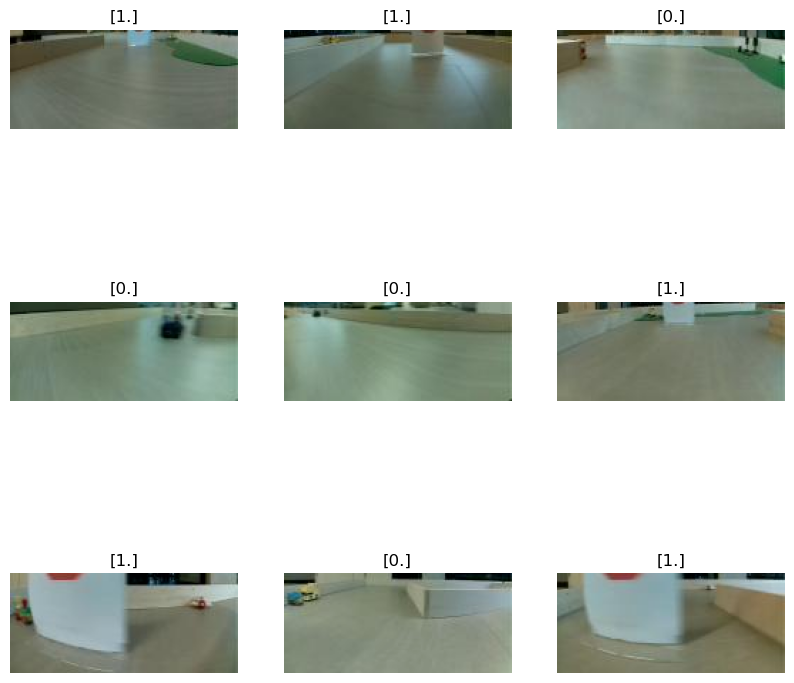

In [46]:
image_batch, label_batch = next(iter(ds_train))
print(image_batch.shape)
print(label_batch.shape)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(reverse_normalization(image_batch[-i].numpy()))
    # plt.imshow((image_batch[-i].numpy() * 255).astype(np.uint8))
    plt.title(label_batch[-i].numpy())
    plt.axis("off")

# Define and Train the Model

In [47]:
# TODO plotting
# TODO Augmentation
# TODO add confusion matrix and choose a threshold using ROC

model = tf.keras.Sequential([
    InputLayer(input_shape=(70, 160, 3)),
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])

n_epochs = 7
log_frequency = 50
threshold = 0.5

optimizer = Adam(learning_rate=0.0001)
criterion = BinaryCrossentropy()

train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(n_epochs):
    step = 0
    # Training
    total_loss = 0.0
    total_accuracy = 0.0
    running_loss = 0.0
    running_accuracy = 0.0
    for step, (image_batch, label_batch) in enumerate(ds_train):
        with tf.GradientTape() as tape:
            logits = model(image_batch, training=True)
            loss_value = criterion(label_batch, logits)
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        # Metrics and Logging
        current_loss = loss_value.numpy()
        current_accuracy = accuracy_score(label_batch, logits > threshold)

        total_loss += current_loss
        total_accuracy += current_accuracy
        running_loss += current_loss
        running_accuracy += current_accuracy

        if (step + 1) % log_frequency == 0:
            print(
                f'Train [{epoch + 1}/{n_epochs}, {step + 1}/?]: '
                f'Loss {running_loss / log_frequency}, '
                f'Accuracy {running_accuracy / log_frequency}'
            )
            running_loss = 0.0
            running_accuracy = 0.0

    train_loss_history.append(total_loss / step)
    train_accuracy_history.append(total_accuracy / step)

    # Validation
    total_loss = 0.0
    total_accuracy = 0.0
    running_loss = 0.0
    running_accuracy = 0.0
    for step, (image_batch, label_batch) in enumerate(ds_val):
        logits = model(image_batch, training=False)
        loss_value = criterion(label_batch, logits)

        # Metrics and Logging
        current_loss = loss_value.numpy()
        current_accuracy = accuracy_score(label_batch, logits > threshold)

        total_loss += current_loss
        total_accuracy += current_accuracy

        running_loss += current_loss
        running_accuracy += current_accuracy
        if (step + 1) % log_frequency == 0:
            print(
                f'Val [{epoch + 1}/{n_epochs}, {step + 1}/?]: '
                f'Loss {running_loss / log_frequency}, '
                f'Accuracy {running_accuracy / log_frequency}'
            )
            running_loss = 0.0
            running_accuracy = 0.0

    val_loss_history.append(total_loss / step)
    val_accuracy_history.append(total_accuracy / step)

Train [1/7, 50/?]: Loss 0.5862676936388016, Accuracy 0.701875
Train [1/7, 100/?]: Loss 0.4209864127635956, Accuracy 0.8225
Train [1/7, 150/?]: Loss 0.3728457403182983, Accuracy 0.8434375
Train [1/7, 200/?]: Loss 0.3479108086228371, Accuracy 0.85375
Train [1/7, 250/?]: Loss 0.3231571918725967, Accuracy 0.8678125
Val [1/7, 50/?]: Loss 0.3476508575677872, Accuracy 0.8634375
Train [2/7, 50/?]: Loss 0.31641496598720553, Accuracy 0.874375
Train [2/7, 100/?]: Loss 0.27303644478321076, Accuracy 0.89
Train [2/7, 150/?]: Loss 0.2773946785926819, Accuracy 0.8903125
Train [2/7, 200/?]: Loss 0.25829408288002015, Accuracy 0.89375
Train [2/7, 250/?]: Loss 0.24753171533346177, Accuracy 0.900625
Val [2/7, 50/?]: Loss 0.29471021503210065, Accuracy 0.88125
Train [3/7, 50/?]: Loss 0.23981234967708587, Accuracy 0.90375
Train [3/7, 100/?]: Loss 0.21930153012275697, Accuracy 0.91625
Train [3/7, 150/?]: Loss 0.21777552634477615, Accuracy 0.92
Train [3/7, 200/?]: Loss 0.1996631506085396, Accuracy 0.9246875
Tra

Text(0.5, 1.0, 'Accuracy')

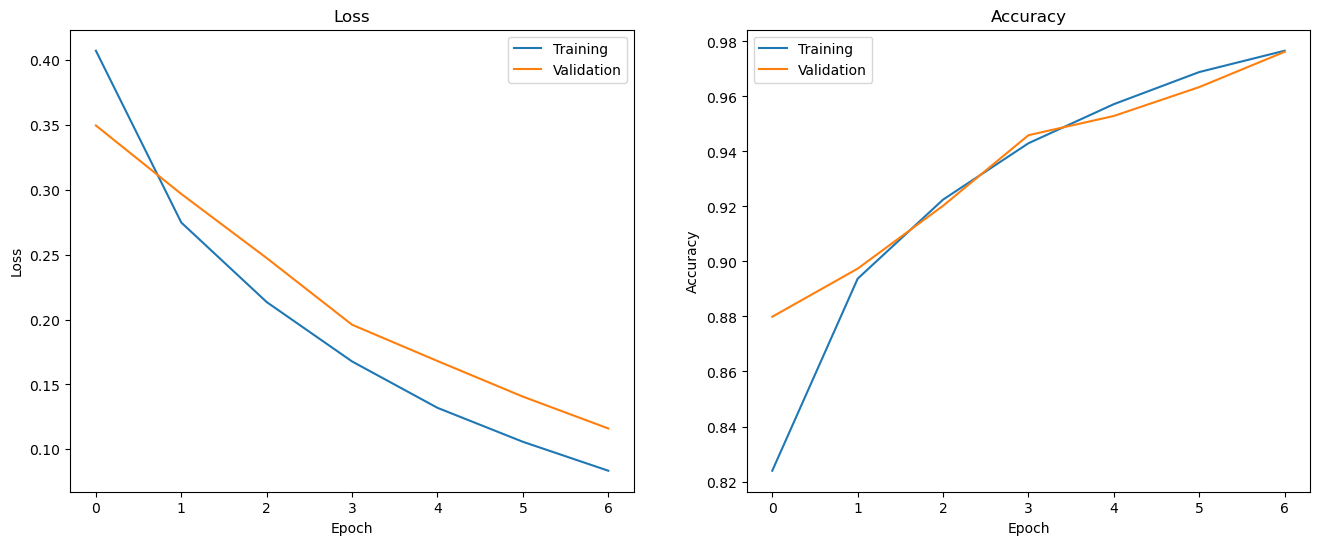

In [48]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history)
plt.plot(val_accuracy_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

In [49]:
# TODO add confusion matrix and choose a threshold using AUC
# Testing
threshold = 0.5

test_loss = 0.0
test_accuracy = 0.0
batches = 0
for step, (image_batch, label_batch) in enumerate(ds_test):
    logits = model(image_batch, training=False)
    loss_value = criterion(label_batch, logits)

    # Metrics and Logging
    current_loss = loss_value.numpy()
    current_accuracy = accuracy_score(label_batch, logits > threshold)

    test_loss += current_loss
    test_accuracy += current_accuracy
    batches += 1

test_loss /= batches
test_accuracy /= batches

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.11497251120837111
Test Accuracy: 0.9599636426592797


In [50]:
model.save("../models/stop_sign_detector_v9")

INFO:tensorflow:Assets written to: ../models/stop_sign_detector_v9/assets
